In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import urllib.request
import shutil
import pywt

from google.colab import drive

drive.mount('/content/drive')

# Change working directory to dataset location
os.chdir("/content/drive/MyDrive/project/E02/test_images")

def download_cascades():
    face_url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml"
    eye_url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml"
    urllib.request.urlretrieve(face_url, "haarcascade_frontalface_default.xml")
    urllib.request.urlretrieve(eye_url, "haarcascade_eye.xml")

download_cascades()

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

# Define dataset paths
path_to_data = "/content/drive/MyDrive/project/E02/Dataset/"
path_to_cr_data = os.path.join(path_to_data, "cropped")



# Create cropped images directory
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]

celebrity_file_names_dict = {}
cropped_image_dirs = []

for img_dir in img_dirs:
    celebrity_name = os.path.basename(img_dir)
    print(f"Processing {celebrity_name}...")
    celebrity_file_names_dict[celebrity_name] = []
    count = 1

    for entry in os.scandir(img_dir):
        if entry.is_file():  # Ensure it's a file before processing
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print(f"Generating cropped images in: {cropped_folder}")

                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing Mark Zuckerberg...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Mark Zuckerberg
Processing Steve Jobs...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Steve Jobs
Processing Jack Ma...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Jack Ma
Processing Jeff Bezos...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Jeff Bezos
Processing Elon Musk...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Elon Musk
Processing cropped...


In [6]:
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Fixed incorrect conversion
    imArray = np.float32(imArray) / 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode) * 255
    return np.uint8(imArray_H)

class_dict = {name: idx for idx, name in enumerate(celebrity_file_names_dict.keys())}

x, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            print(f"Error reading {training_image}")
            continue

        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img = cv2.resize(img_har, (32, 32))

        combined_img = np.vstack((scaled_raw_img.reshape(32 * 32 * 3, 1),
                                  scaled_img.reshape(32 * 32, 1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

print(f"Dataset size: {len(x)} images")


Dataset size: 57 images


In [7]:
len(x)
len(y)
len(x[0])


4096

In [8]:
32*32*3 + 32*32

4096

In [9]:
x[0]

array([[  6],
       [  6],
       [  6],
       ...,
       [121],
       [127],
       [127]], dtype=uint8)

In [10]:
x = np. array(x).reshape(len(x), 4096).astype(float)
x.shape

(57, 4096)

In [11]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.4

In [13]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
           4       0.31      1.00      0.47         4

    accuracy                           0.40        15
   macro avg       0.26      0.30      0.23        15
weighted avg       0.35      0.40      0.30        15



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [15]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [16]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and

,model,best_score,best_params
0,svm,0.716667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.447222,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.616667,{'logisticregression__C': 10}


In [17]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, multi_class='auto',
                                     solver='liblinear'))])}

In [18]:
best_estimators['svm'].score(X_test,y_test)

0.5333333333333333

In [19]:
best_estimators['random_forest'].score(X_test,y_test)

0.6666666666666666

In [20]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6

In [21]:
best_clf = max(best_estimators, key=lambda k: best_estimators[k].score(X_test, y_test))
best_clf = best_estimators[best_clf]
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=5))])

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[4, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 2, 0, 2],
       [0, 0, 0, 0, 4]])

Text(95.72222222222221, 0.5, 'Truth')

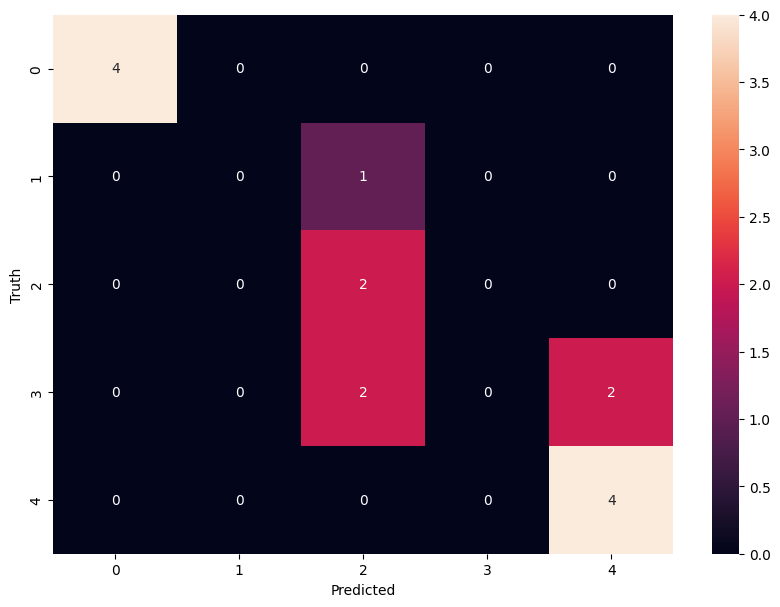

In [23]:

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [24]:

class_dict

{'Mark Zuckerberg': 0,
 'Steve Jobs': 1,
 'Jack Ma': 2,
 'Jeff Bezos': 3,
 'Elon Musk': 4,
 'cropped': 5}

In [25]:
!pip install joblib
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [26]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))